In [1]:
%reset -f
%matplotlib inline
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

import rpy2.robjects as ro
import numpy as np
import seaborn.apionly as sns
import pylab as pl
import pandas as pd
import scipy.stats as stats
from sys import stdout
from QNEM.inference import QNEM
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier as GradientBoosting
from sklearn.neural_network import MLPClassifier
from tick.inference import LogisticRegression
from data_management import generate_data, compute_score
from lifelines.estimation import KaplanMeierFitter
from lifelines.utils import concordance_index as c_index_score
from time import time
from prettytable import PrettyTable

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [3]:
# randomly choose one visit per patient
verbose = True
X, Y, delta = generate_data(verbose)

# Binary features names
binary_features = ['Gender', 'Stayed in ICU', 'Household situation', 
                   'Professional activity', 'Genotype',
                   'History of acute\nchest syndrom', 
                   'History of avascular\nbone necrosis',
                   'Formerly or currently\non a dialysis protocol',
                   'History of heart\nfailure', 'History of\nischemic stroke',
                   'History of leg\nskin ulceration', 'History of\nknown nephropathy',
                   'History of pulmonary\nhypertension', 'History of priapism*',
                   'History of known\nretinopathy',
                   'Received orally\nadministered opioids', 'Received Morphine',
                   'Received Oxycodone', 'Less than 18 months\nsince last visit',
                   'GHM=1', 'GHM=2', 'GHM=3', 'GHM=4']

print("X shape: %s" % str(X.shape))
# first lines visualisation
X.head()

Features generation: pick 1 visit per patient randomly
Matrix with all visits loaded
n_visits = 286
Censoring rate: 70.28%
X shape: (286, 174)


,Household situation,Professional activity,History of acute chest syndrom,History of avascular bone necrosis,Formerly or currently on a dialysis protocol,History of heart failure,History of ischemic stroke,History of leg skin ulceration,History of known nephropathy,History of pulmonary hypertension,...,intercept refactory period,Delay between syringes (slope),Syringe frequency (per day),Post-opioid observation period (hours),GHM=1,GHM=2,GHM=3,GHM=4,dist,drive
2011481340,0.0,1.0,1,0,0,0,0,0,0,0,...,7.000000,2.425000,0.020986,649.433333,0.0,0.0,1.0,0.0,6.177,14.266667
2011481342,0.0,0.0,1,0,0,0,1,1,0,1,...,7.000000,2.425000,0.004913,311.116667,0.0,0.0,1.0,0.0,1.969,7.183333
2011623705,0.0,1.0,1,0,0,0,0,0,0,0,...,7.000000,-0.148333,0.020104,86.900000,0.0,0.0,1.0,0.0,12.148,20.150000
2009006222,1.0,0.0,1,1,0,0,0,0,0,0,...,0.077052,2.425000,0.004363,215.283333,0.0,1.0,0.0,0.0,27.963,32.183333
2008169482,0.0,0.0,0,1,0,0,0,0,0,0,...,7.000000,2.425000,0.020986,103.183333,1.0,0.0,0.0,0.0,20.340,29.766667


# Binary thresholded setting

In [4]:
threshold = 30 # days
verbose = True
X, Y, delta = generate_data(verbose)

print("%.1f%% of the visits lead to a relapse within 30 days" 
      % (100 * np.sum(Y[delta == 1] < 30) / X.shape[0]))

# Keep valid examples only
idx2keep = ~np.logical_and(delta == 0, Y <= threshold)
Y = Y[idx2keep]
X = X[idx2keep]
features_names = X.columns

Y_bin = (Y <= threshold).astype(int)

# Separate continuous and binary features
X_bin = X[binary_features]
X_bin.index = range(X.shape[0])
X_cont = X.drop(binary_features, axis=1)
features_names_cont = X_cont.columns 

# Center and reduce continuous data
standardscaler = StandardScaler()
X_cont_std = pd.DataFrame(standardscaler.fit_transform(X_cont),
                     columns=features_names_cont)
X_cont = pd.DataFrame(X_cont.as_matrix(), columns=features_names_cont)

# Merge features
X_std = pd.concat([X_cont_std, X_bin], axis=1)
X = pd.concat([X_cont, X_bin], axis=1)
X.shape

Features generation: pick 1 visit per patient randomly
Matrix with all visits loaded
n_visits = 286
Censoring rate: 68.18%
5.2% of the visits lead to a relapse within 30 days


(279, 174)

## Data splitting

In [5]:
features_names = X.columns
n_samples, n_features = X.shape
X = X.as_matrix()
X_std = X_std.as_matrix()

# Split data into training and test sets
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X[test_index]
    X_test_std = X_std[test_index]
    delta_test = delta[test_index]
    Y_test_bin = Y_bin[test_index]

    X = X[train_index]
    X_std = X_std[train_index]
    Y_bin = Y_bin[train_index]
    delta = delta[train_index]  
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

results = PrettyTable(['Models', 'AUC', 'time'])

# Initialize metadata
meta_data = dict()
meta_data["coeffs"] = dict()
meta_data["predictions"] = dict()
meta_data["auc"] = dict()
meta_data["times"] = dict()

# CV params
C_grid_size = 20
K = 3
n_iter_search = 50

70% for training, 30% for testing.


### Log reg

In [7]:
model = "LR"
print("Launch %s" % model)

C_grid = np.logspace(1, 3, C_grid_size)
selection = 'min'

# cross validation on C
avg_scores, score_test = np.empty(0), []
for i, C_ in enumerate(C_grid):
    stdout.write("\rCV %s: %d%%" % (model, (i + 1) * 100 / C_grid_size))
    stdout.flush()

    learners = [LogisticRegression(penalty="elasticnet", solver='svrg',
                                   C=C_, verbose=False, step=1e-3)
                for _ in range(K)]
    
    auc = compute_score(learners, X_std, Y_bin, K, verbose=False)[0]

    avg_scores = np.append(avg_scores, max(auc, 1 - auc))
    learner = LogisticRegression(penalty="elasticnet", solver='svrg',
                                 C=C_, verbose=False, step=1e-3)

    learner.fit(X_std, Y_bin)
    y_pred = learner.predict_proba(X_test_std)[:, 1]
    score_test.append(roc_auc_score(Y_test_bin, y_pred))
    
idx_best = np.unravel_index(avg_scores.argmax(),
                            avg_scores.shape)[0]
C_best = C_grid[idx_best]
max_ = avg_scores.max()
min_ = avg_scores.min()
idx = [i for i, is_up in enumerate(
    list(avg_scores >= max_ - .05 * (max_ - min_)))
       if is_up]
idx_chosen = min(idx) if len(idx) > 0 else idx_best
C_chosen = C_grid[idx_chosen]
print("\nC_chosen=%s" % C_chosen)

start = time()
learner = LogisticRegression(penalty="elasticnet", C=C_chosen, 
                             solver='svrg', step=1e-3)

learner.fit(X_std, Y_bin)
y_pred = learner.predict_proba(X_test_std)[:, 1]
computing_time = time() - start
coeffs = learner.weights
auc = roc_auc_score(Y_test_bin, y_pred)
auc = max(auc, 1 - auc)

# Save results
meta_data.get('coeffs')[model] = coeffs
meta_data.get('predictions')[model] = y_pred
meta_data.get('auc')[model] = auc
meta_data.get('times')[model] = computing_time

Launch LR
CV LR: 100%
C_chosen=54.5559478117


### SVM

In [8]:
model = "SVM"
print("Launch %s" % model)

C_grid = np.logspace(-2, 0, 30)
selection = 'min'
l1_ratio = .1

# cross validation on C
avg_scores, score_test = np.empty(0), []
for i, C_ in enumerate(C_grid):
    stdout.write("\rCV %s: %d%%" % (model, (i + 1) * 100 / C_grid_size))
    stdout.flush()
        
    learners = [linear_model.SGDClassifier(loss='hinge', penalty='elasticnet',
                                           alpha=C_, l1_ratio=l1_ratio, 
                                           fit_intercept=True, n_jobs=3)
                for _ in range(K)]
    
    auc = compute_score(learners, X_std, Y_bin, K, verbose=False)[0]

    avg_scores = np.append(avg_scores, max(auc, 1 - auc))
    learner = linear_model.SGDClassifier(loss='hinge', penalty='elasticnet', 
                                         alpha=C_, l1_ratio=l1_ratio, 
                                         fit_intercept=True, n_jobs=5)

    learner.fit(X_std, Y_bin)
    y_pred = learner.predict(X_test_std)
    score_test.append(roc_auc_score(Y_test_bin, y_pred))

idx_best = np.unravel_index(avg_scores.argmax(),
                            avg_scores.shape)[0]
C_best = C_grid[idx_best]
if selection == 'min':
    C_chosen = C_best
if selection == '1st':
    max_ = avg_scores.max()
    min_ = avg_scores.min()
    idx = [i for i, is_up in enumerate(
        list(avg_scores >= max_ - .05 * (max_ - min_)))
           if is_up]
    idx_chosen = min(idx) if len(idx) > 0 else idx_best
    C_chosen = C_grid[idx_chosen]
    
print("\nC_chosen=%s" % C_chosen)
    
start = time()
learner = linear_model.SGDClassifier(loss='hinge', penalty='elasticnet',
                                     alpha=C_chosen, l1_ratio=l1_ratio, 
                                     fit_intercept=True, n_jobs=5)

learner.fit(X_std, Y_bin)
y_pred = learner.predict(X_test_std)
computing_time = time() - start
coeffs = np.ravel(learner.coef_)
auc = roc_auc_score(Y_test_bin, y_pred)
auc = max(auc, 1 - auc)

# Save results
meta_data.get('coeffs')[model] = coeffs
meta_data.get('predictions')[model] = y_pred
meta_data.get('auc')[model] = auc
meta_data.get('times')[model] = computing_time

Launch SVM
CV SVM: 150%
C_chosen=0.0923670857187


### RF

In [9]:
model = "RF"

learner = RandomForest(n_jobs=5)
param_dist = {"max_depth": [None, 3, 5, 7],
              "min_samples_split": stats.randint(2, 5),
              "min_samples_leaf": stats.randint(2, 20),
              "n_estimators": [100, 200, 300],
              "criterion": ["entropy"]}

cv = StratifiedKFold(Y_bin, n_folds=K, shuffle=True)

search = RandomizedSearchCV(learner,
                            param_distributions=param_dist,
                            n_iter=n_iter_search, scoring="roc_auc",
                            verbose=1, n_jobs=10, cv=cv)
search.fit(X, Y_bin)

infos = "max_depth: %s, min_samples_split: %s, min_samples_leaf: %s," \
        " criterion: %s, n_estimators: %s" \
        % (search.best_params_['max_depth'],
           search.best_params_['min_samples_split'],
           search.best_params_['min_samples_leaf'],
           search.best_params_['criterion'],
           search.best_params_['n_estimators'])
print(infos)

start = time()
learner = RandomForest(max_depth=search.best_params_['max_depth'],
                       min_samples_split=search.best_params_['min_samples_split'],
                       min_samples_leaf=search.best_params_['min_samples_leaf'],
                       criterion=search.best_params_['criterion'],
                       n_estimators=search.best_params_['n_estimators'])

learner.fit(X, Y_bin)
y_pred = learner.predict_proba(X_test)[:, 1]
computing_time = time() - start
coeffs = learner.feature_importances_
auc = roc_auc_score(Y_test_bin, y_pred)
auc = max(auc, 1 - auc)

## Save results ##
meta_data.get('coeffs')[model] = coeffs
meta_data.get('predictions')[model] = y_pred
meta_data.get('auc')[model] = auc
meta_data.get('times')[model] = computing_time

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   23.6s finished


max_depth: 3, min_samples_split: 4, min_samples_leaf: 4, criterion: entropy, n_estimators: 100


### GB

In [10]:
model = "GB"

learner = GradientBoosting()
param_dist = {"max_depth": [None, 3, 5, 7],
              "min_samples_split": stats.randint(2, 5),
              "min_samples_leaf": stats.randint(2, 20),
              "n_estimators": [100, 200, 300]}

cv = StratifiedKFold(Y_bin, n_folds=K, shuffle=True)
search = RandomizedSearchCV(learner,
                            param_distributions=param_dist,
                            n_iter=n_iter_search, scoring="roc_auc",
                            verbose=1, n_jobs=10, cv=cv)
search.fit(X, Y_bin)

infos = "max_depth: %s, min_samples_split: %s, min_samples_leaf: %s," \
        " n_estimators: %s" \
        % (search.best_params_['max_depth'],
           search.best_params_['min_samples_split'],
           search.best_params_['min_samples_leaf'],
           search.best_params_['n_estimators'])
print(infos)

start = time()
learner = GradientBoosting(max_depth=search.best_params_['max_depth'],
                           min_samples_split=search.best_params_['min_samples_split'],
                           min_samples_leaf=search.best_params_['min_samples_leaf'],
                           n_estimators=search.best_params_['n_estimators'])
learner.fit(X, Y_bin)
y_pred = learner.predict_proba(X_test)[:, 1]
computing_time = time() - start
coeffs = learner.feature_importances_
auc = roc_auc_score(Y_test_bin, y_pred)
auc = max(auc, 1 - auc)

## Save results ##
meta_data.get('coeffs')[model] = coeffs
meta_data.get('predictions')[model] = y_pred
meta_data.get('auc')[model] = auc
meta_data.get('times')[model] = computing_time

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.7s finished


max_depth: 5, min_samples_split: 3, min_samples_leaf: 5, n_estimators: 200


### NN

In [11]:
model = "NN"

alpha_grid = np.logspace(-3, 1, 20)

learner = MLPClassifier()
param_dist = {"hidden_layer_sizes": [(3,), (4,), (5,), (6,)],
              "alpha": list(alpha_grid)}

cv = StratifiedKFold(Y_bin, n_folds=K, shuffle=True)
search = RandomizedSearchCV(learner,
                            param_distributions=param_dist,
                            n_iter=n_iter_search, scoring="roc_auc",
                            verbose=1, n_jobs=10, cv=cv)
search.fit(X_std, Y_bin)

infos = "hidden_layer_sizes: %s, alpha: %s" \
        % (search.best_params_['hidden_layer_sizes'],
           search.best_params_['alpha'])
print(infos)

start = time()
learner = MLPClassifier(hidden_layer_sizes=search.best_params_['hidden_layer_sizes'],
                       alpha=search.best_params_['alpha'])
learner.fit(X_std, Y_bin)
y_pred = learner.predict_proba(X_test_std)[:, 1]
computing_time = time() - start
auc = roc_auc_score(Y_test_bin, y_pred)
auc = max(auc, 1 - auc)

## Save results ##
meta_data.get('predictions')[model] = y_pred
meta_data.get('auc')[model] = auc
meta_data.get('times')[model] = computing_time

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.2s finished


hidden_layer_sizes: (6,), alpha: 0.206913808111


# Survival analysis setting

In [12]:
verbose = True
X, Y, delta = generate_data(verbose)

print("%.1f%% of the visits lead to a relapse within 30 days" 
      % (100 * np.sum(Y[delta == 1] < 30) / X.shape[0]))

# Separate continuous and binary features
X_bin = X[binary_features]
X_bin.index = range(X.shape[0])
X_cont = X.drop(binary_features, axis=1)
features_names_cont = X_cont.columns 

# Center and reduce continuous data
standardscaler = StandardScaler()
X_cont_std = pd.DataFrame(standardscaler.fit_transform(X_cont),
                     columns=features_names_cont)
X_cont = pd.DataFrame(X_cont.as_matrix(), columns=features_names_cont)

# Merge features
X_std = pd.concat([X_cont_std, X_bin], axis=1)
X = pd.concat([X_cont, X_bin], axis=1)

Features generation: pick 1 visit per patient randomly
Matrix with all visits loaded
n_visits = 286
Censoring rate: 68.18%
5.2% of the visits lead to a relapse within 30 days


## Data splitting

In [13]:
features_names = X.columns 
n_samples, n_features = X.shape
X_copy = X_std.copy()
X = X.as_matrix()
X_std = X_std.as_matrix()

# Split data into training and test sets
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X[test_index]
    X_test_std = X_std[test_index]
    delta_test = delta[test_index]
    Y_test = Y[test_index]

    X = X[train_index]
    X_std = X_std[train_index]
    Y = Y[train_index]
    delta = delta[train_index]  
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

results = PrettyTable(['Models', 'AUC', 'time'])

70% for training, 30% for testing.


## Training 

In [14]:
# Initialize metadata
meta_data["c_index"] = dict()
meta_data["survival"] = dict()
meta_data["marker"] = dict()
meta_data["n_iter"] = dict()
meta_data["obj"] = dict()

### C-mix & CURE in high dimension (QNEM)

https://arxiv.org/pdf/1610.07407.pdf

In [15]:
for model in ["C-mix", "CURE"]:

    ## Choose parameters ##
    tol = 1e-7            # tolerance for the convergence stopping criterion 
    eta = 0.2             # parameter controlling the trade-off between l1 
                          # and l2 regularization in the elasticNet
    fit_intercept = True  # whether or not an intercept term is fitted
    warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                          # the previous value  

    if verbose:
        print("\nLaunching %s...\n" % model)
        
        
        
    if model == "C-mix":
        l_elastic_net_chosen = .3e-1 # for results
        #l_elastic_net_chosen = .1e-1 # for figure
        
        
        
    if model == "CURE":
        l_elastic_net_chosen = 0.008 #.3e-1
        
    ## Run selected model with l_elasticNet_chosen ##
    start = time()
    learner = QNEM(l_elastic_net=l_elastic_net_chosen, eta=eta, tol=tol,
                   warm_start=warm_start, verbose=verbose, model=model,
                   fit_intercept=fit_intercept)
    learner.n_features = n_features
    learner.fit(X_std, Y, delta)  

    ## Obtain the marker vector on test set ##
    coeffs = learner.coeffs
    marker = QNEM.predict_proba(X_test_std, fit_intercept, coeffs) 
    computing_time = time() - start    
    c_index = c_index_score(Y_test, marker, delta_test)
    c_index = max(c_index, 1 - c_index)
        
    ## Save results ##
    meta_data.get('coeffs')[model] = coeffs
    meta_data.get('marker')[model] = marker
    meta_data.get('c_index')[model] = c_index
    meta_data.get('n_iter')[model] = learner.get_history("n_iter")
    meta_data.get('obj')[model] = learner.get_history("obj")
    meta_data.get('times')[model] = computing_time


Launching C-mix...

Launching the solver QNEM...
init: p0=8.58106823886e-05
init: p1=0.00371922634838
 n_iter  |   obj    | rel_obj 
       0 |  8.28227 |        1
       1 |  8.18324 | 0.0119565
       2 |  8.17805 | 0.000635158
       3 |    8.177 | 0.000128104
       4 |  8.17673 | 3.28856e-05
       5 |  8.17665 | 9.96167e-06
       6 |  8.17661 | 4.11852e-06
       7 |  8.17659 | 2.51591e-06
       8 |  8.17658 | 1.95473e-06
       9 |  8.17656 | 1.70865e-06
      10 |  8.17655 | 1.56081e-06
      11 |  8.17654 | 1.44532e-06
      12 |  8.17653 | 1.34802e-06
      13 |  8.17652 | 1.26407e-06
      14 |  8.17651 | 1.19103e-06
      15 |   8.1765 | 1.12723e-06
      16 |  8.17649 | 1.07243e-06
      17 |  8.17648 | 1.02355e-06
      18 |  8.17647 | 9.80559e-07
      19 |  8.17647 | 9.42321e-07
      20 |  8.17646 | 9.09588e-07
      21 |  8.17645 | 8.80749e-07
      22 |  8.17644 | 8.53784e-07
      23 |  8.17644 | 8.32397e-07
      24 |  8.17643 | 8.13604e-07
      25 |  8.17642 |

### Cox PH

In [16]:
model = "Cox PH"       
print("\nLaunching Cox PH...\n")

eta = .1
nfolds = 10

%R -i X_std,Y,delta,X_test_std,Y_test,delta_test,eta,nfolds
%R library(survival)
%R library(ggfortify)
%R library(glmnet)
%R cv = cv.glmnet(as.matrix(X_std),\
                  Surv(time=Y, event=delta, type="right"),\
                  family="cox",\
                  alpha=1-eta,\
                  nfolds=nfolds)
%R coeffs <- as.matrix(coef(cv, s="lambda.min"))
start = time()
%R fit_coxph = coxph(Surv(Y,delta)~X_std[,which((coeffs!=0))])
%R marker = exp(X_test_std %*% coeffs)
%R marker_train = exp(X_std %*% coeffs)
computing_time = time() - start 
%R baselinecum = basehaz(fit_coxph)

# Survival estimation on test set for Cox PH
%R times = baselinecum[,2]
%R survival = exp(- matrix(rep(baselinecum[,1],length(Y_test)),\
                           nrow=length(Y_test),\
                           byrow=TRUE)\
                  * matrix(rep(marker,\
                               nrow(baselinecum)),\
                           ncol=nrow(baselinecum))\
                 )
%R -o marker,survival,times,coeffs

c_index = c_index_score(Y_test, marker, delta_test)
c_index = max(c_index, 1 - c_index)

meta_data.get('coeffs')[model] = np.array(coeffs)
meta_data.get('marker')[model] = marker
meta_data.get('c_index')[model] = c_index
meta_data.get('survival')[model] = np.array(survival)
meta_data.get('times')[model] = computing_time
print("Done!")


Launching Cox PH...

Done!


# Prediction

In [17]:
print("\nResults on prediction:\n")

t = PrettyTable(['Model', 'AUC', 'Times (sec)']) 
for model, auc in meta_data.get('auc').items():
    computing_times = meta_data.get('times').get(model)
    t.add_row([model.replace('_', ' '), "%g" % auc,
               "%.3f" % computing_times])
print(t)

t = PrettyTable(['Model', 'C-index', 'Times (sec)']) 
for model, c_index in meta_data.get('c_index').items():
    computing_times = meta_data.get('times').get(model)
    t.add_row([model, "%.3f" % c_index,
               "%.3f" % computing_times])
print(t)


Results on prediction:

+-------+----------+-------------+
| Model |   AUC    | Times (sec) |
+-------+----------+-------------+
|   LR  | 0.756098 |    0.160    |
|  SVM  | 0.506098 |    0.002    |
|   RF  | 0.542683 |    0.141    |
|   GB  | 0.609756 |    0.325    |
|   NN  | 0.542683 |    0.104    |
+-------+----------+-------------+
+--------+---------+-------------+
| Model  | C-index | Times (sec) |
+--------+---------+-------------+
| C-mix  |  0.753  |    0.505    |
|  CURE  |  0.686  |    0.365    |
| Cox PH |  0.763  |    0.024    |
+--------+---------+-------------+


# Figures

### $\hat \beta$ coefficient

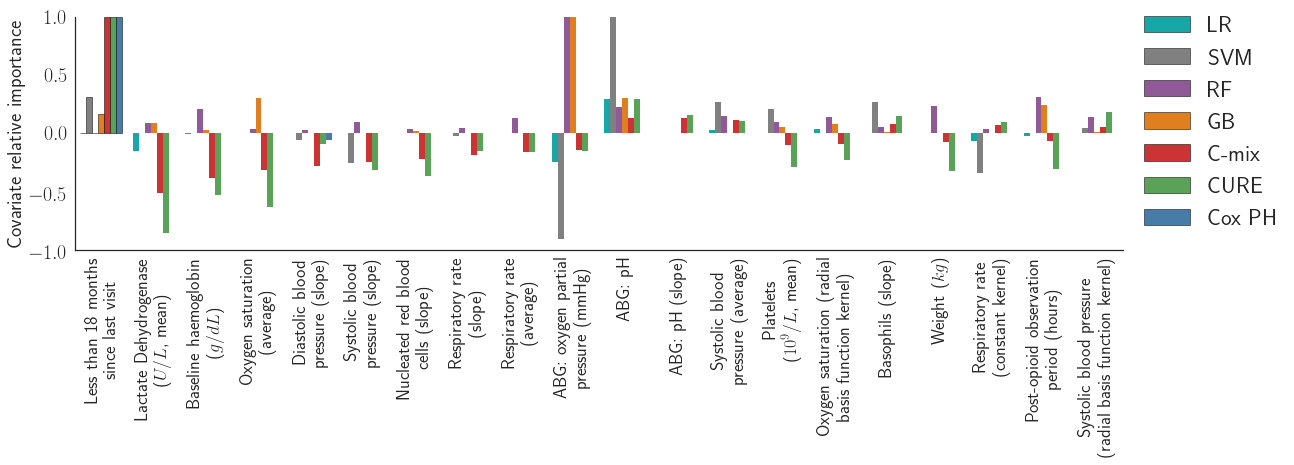

In [18]:
models_binary = ["LR", "SVM", "RF", "GB"]
models_survival = ["C-mix", "CURE", "Cox PH"]
all_coeffs = pd.DataFrame()

for model in models_binary + models_survival:
    coeffs = meta_data.get('coeffs').get(model) 
    if model in ["C-mix", "CURE"] and fit_intercept:
        coeffs = -coeffs[1:]
    # standardize vector
    coeffs_min, coeffs_max = min(abs(coeffs)), max(abs(coeffs))
    coeffs = (coeffs - coeffs_min) / (coeffs_max - coeffs_min)
    if model == "C-mix":
        coeffs_cmix = pd.DataFrame(np.atleast_2d(coeffs), columns=features_names)
    coeffs = np.append(model , coeffs)    
    all_coeffs = all_coeffs.append(pd.DataFrame(np.atleast_2d(coeffs), 
                                                columns=np.append('Models', features_names)))

coeffs_ordered = coeffs_cmix.median().abs().sort_values(ascending=False)
order = ['Models'] + list(coeffs_ordered.index)
all_coeffs = all_coeffs.reindex_axis(order, axis=1)

# plot only the first 20 features:
all_coeffs = all_coeffs.ix[:, :21]

colors = pl.cm.Set1(np.linspace(0, .5, 5))
palette = {
    'LR': 'c',
    'Cox PH': colors[1],
    'C-mix': colors[0],
    'CURE': colors[2],
    'RF': colors[3],
    'GB': colors[4],
    'SVM': 'grey'
}

half_d = int(len(features_names) / 2)
all_coeffs1, all_coeffs2 = all_coeffs.ix[:, :half_d], all_coeffs.ix[:, half_d:]
all_coeffs2['Models'] = all_coeffs['Models']
data1 = all_coeffs1.set_index('Models').unstack().reset_index().convert_objects(convert_numeric=True)
data2 = all_coeffs2.set_index('Models').unstack().reset_index().convert_objects(convert_numeric=True)
data1.columns = ['','Models', 'Covariate relative importance']
data2.columns = ['','Models', 'Covariate relative importance']

sns.set(style="white")
sns.set_context(rc = {'patch.linewidth': 1.0})

pl.figure(figsize=(10, 18))
g = sns.factorplot(x='',
                   y= 'Covariate relative importance',
                   hue='Models',
                   data=data1,
                   kind='bar',
                   aspect=4,
                   palette=palette,
                   legend=False,
                   edgecolor='black',
                   linewidth=.5)

g.set_ylabels(fontsize = 20)
g.set_xticklabels(rotation=90, fontsize = 18)
pl.ylim(-1, 1)
pl.tick_params(axis='y', which='major', labelsize=20)
pl.legend(bbox_to_anchor=(1, 1.09), fontsize=23)
pl.savefig('./figures/final/beta_20.pdf', bbox_inches='tight')
pl.show()

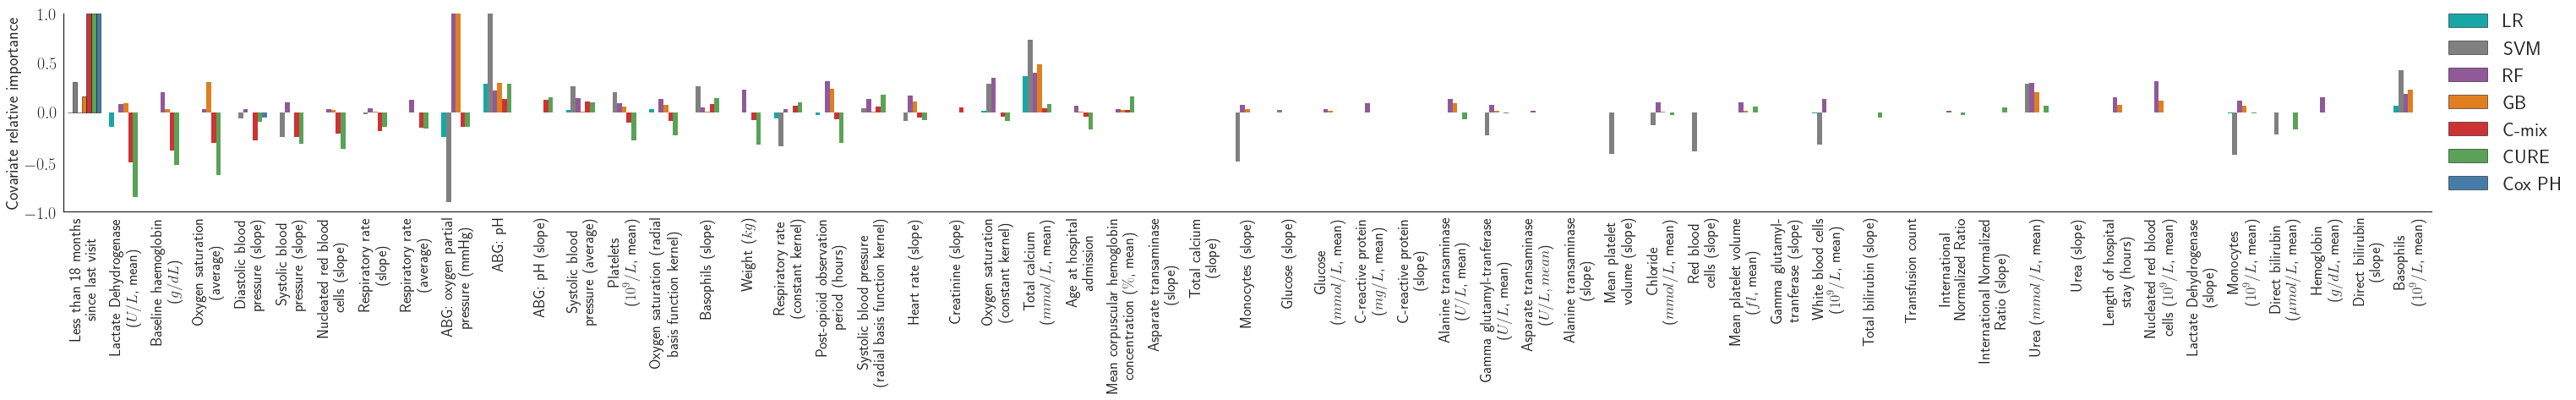

In [19]:
models_binary = ["LR", "SVM", "RF", "GB"]
models_survival = ["C-mix", "CURE", "Cox PH"]
all_coeffs = pd.DataFrame()

for model in models_binary + models_survival:
    coeffs = meta_data.get('coeffs').get(model) 
    if model in ["C-mix", "CURE"] and fit_intercept:
        coeffs = -coeffs[1:]
    # standardize vector
    coeffs_min, coeffs_max = min(abs(coeffs)), max(abs(coeffs))
    coeffs = (coeffs - coeffs_min) / (coeffs_max - coeffs_min)
    if model == "C-mix":
        coeffs_cmix = pd.DataFrame(np.atleast_2d(coeffs), columns=features_names)
    coeffs = np.append(model , coeffs)    
    all_coeffs = all_coeffs.append(pd.DataFrame(np.atleast_2d(coeffs), 
                                                columns=np.append('Models', features_names)))

coeffs_ordered = coeffs_cmix.median().abs().sort_values(ascending=False)
order = ['Models'] + list(coeffs_ordered.index)
all_coeffs = all_coeffs.reindex_axis(order, axis=1)


colors = pl.cm.Set1(np.linspace(0, .5, 5))
palette = {
    'LR': 'c',
    'Cox PH': colors[1],
    'C-mix': colors[0],
    'CURE': colors[2],
    'RF': colors[3],
    'GB': colors[4],
    'SVM': 'grey'
}

half_d = int(len(features_names) / 3)
all_coeffs1, all_coeffs2, all_coeffs3 = all_coeffs.ix[:, :half_d], all_coeffs.ix[:, half_d:2*half_d], all_coeffs.ix[:, 2*half_d:]
all_coeffs2['Models'] = all_coeffs['Models']
all_coeffs3['Models'] = all_coeffs['Models']
data1 = all_coeffs1.set_index('Models').unstack().reset_index().convert_objects(convert_numeric=True)
data2 = all_coeffs2.set_index('Models').unstack().reset_index().convert_objects(convert_numeric=True)
data3 = all_coeffs3.set_index('Models').unstack().reset_index().convert_objects(convert_numeric=True)
data1.columns = ['','Models', 'Covariate relative importance']
data2.columns = ['','Models', 'Covariate relative importance']
data3.columns = ['','Models', 'Covariate relative importance']

sns.set(style="white")
sns.set_context(rc = {'patch.linewidth': 1.0})

pl.figure(figsize=(10, 18))
g = sns.factorplot(x='',
                   y= 'Covariate relative importance',
                   hue='Models',
                   data=data1,
                   kind='bar',
                   aspect=10,
                   palette=palette,
                   legend=False,
                   edgecolor='black',
                   linewidth=.5)

g.set_ylabels(fontsize = 20)
g.set_xticklabels(rotation=90, fontsize = 18)
pl.ylim(-1, 1)
pl.tick_params(axis='y', which='major', labelsize=20)
pl.legend(bbox_to_anchor=(1, 1.09), fontsize=23)
pl.savefig('./figures/final/beta1.pdf', bbox_inches='tight')
pl.show()

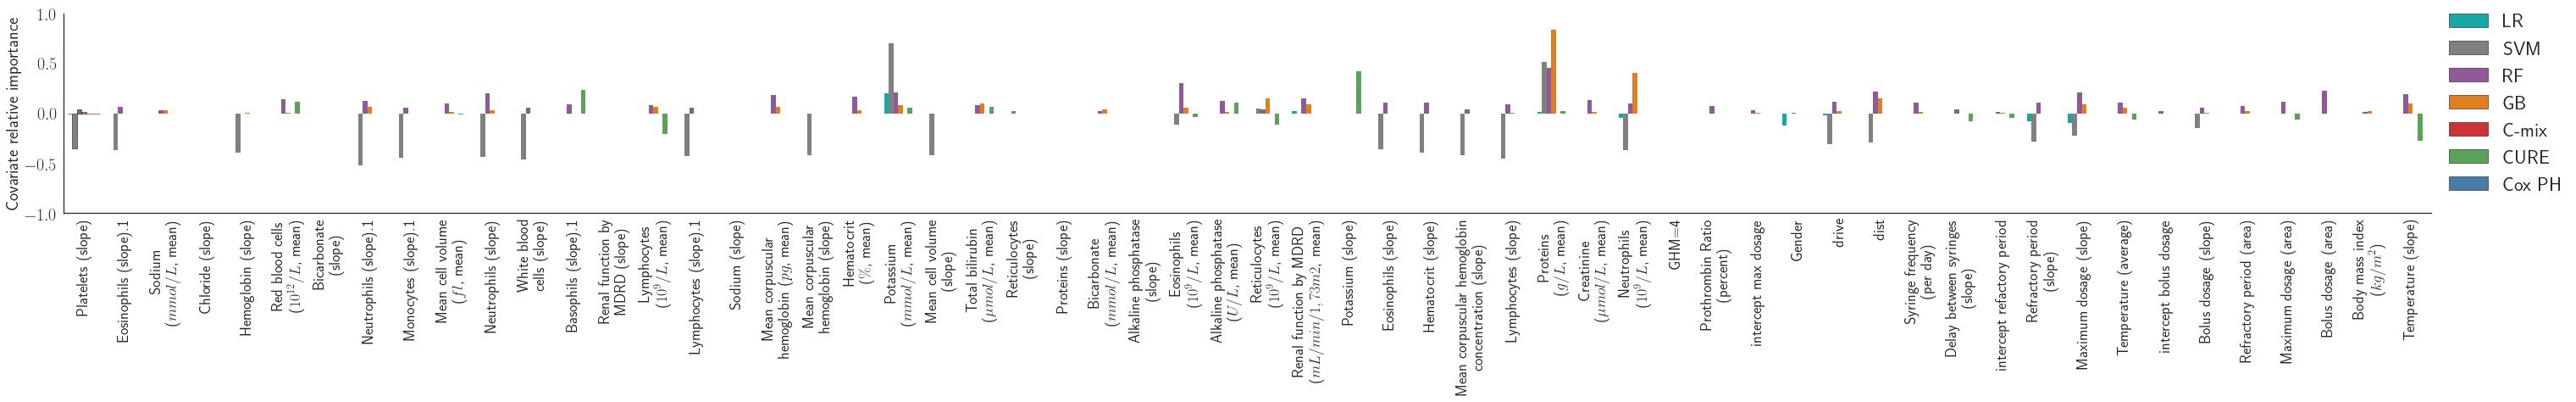

In [20]:
pl.figure(figsize=(40, 14))
g = sns.factorplot(x='',
                   y= 'Covariate relative importance',
                   hue='Models',
                   data=data2,
                   kind='bar',
                   aspect=10,
                   palette=palette,
                   legend=False,
                   edgecolor='black',
                   linewidth=.5)

g.set_ylabels(fontsize = 20)
g.set_xticklabels(rotation=90, fontsize = 18)
pl.ylim(-1, 1)
pl.tick_params(axis='y', which='major', labelsize=20)
pl.legend(bbox_to_anchor=(1, 1.09), fontsize=23)
pl.savefig('./figures/final/beta2.pdf', bbox_inches='tight')
pl.show()

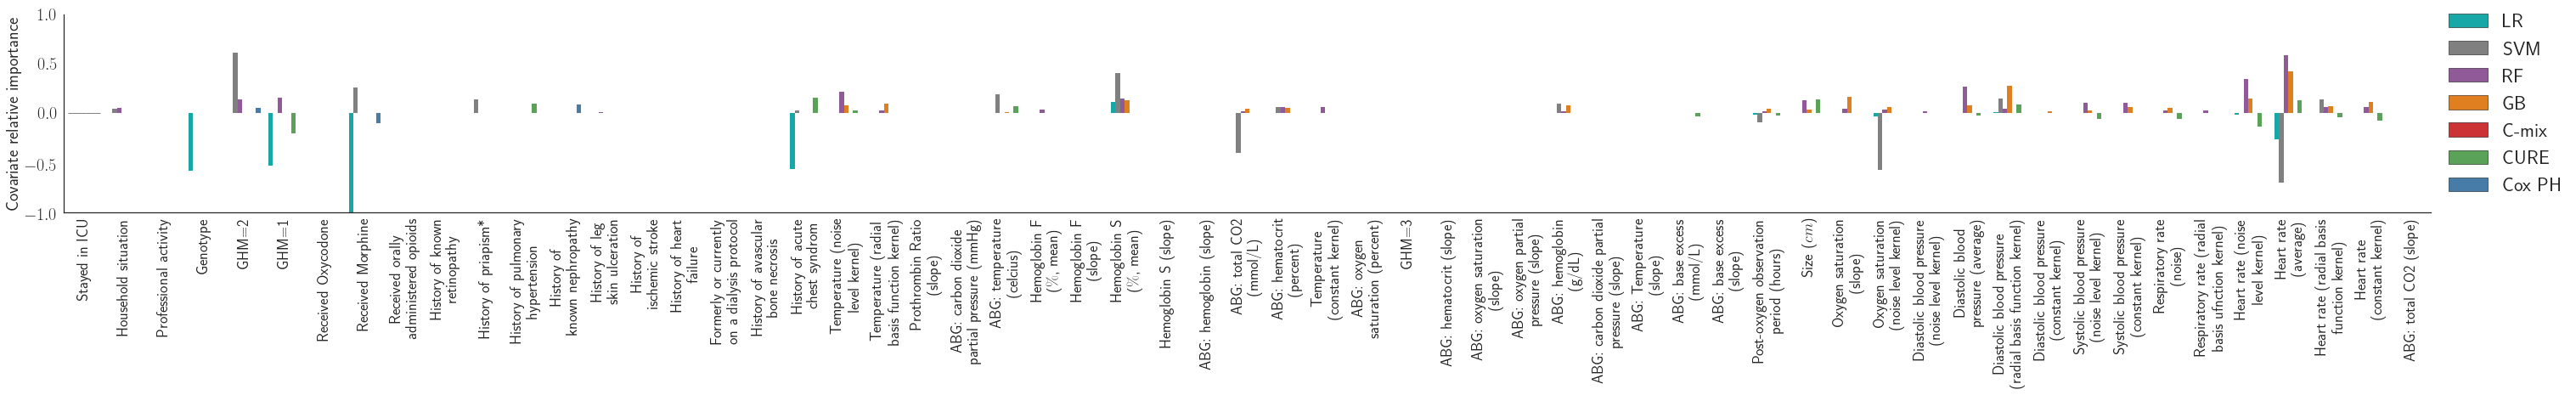

In [21]:
pl.figure(figsize=(40, 14))
g = sns.factorplot(x='',
                   y= 'Covariate relative importance',
                   hue='Models',
                   data=data3,
                   kind='bar',
                   aspect=10,
                   palette=palette,
                   legend=False,
                   edgecolor='black',
                   linewidth=.5)

g.set_ylabels(fontsize = 20)
g.set_xticklabels(rotation=90, fontsize = 18)
pl.ylim(-1, 1)
pl.tick_params(axis='y', which='major', labelsize=20)
pl.legend(bbox_to_anchor=(1, 1.09), fontsize=23)
pl.savefig('./figures/final/beta3.pdf', bbox_inches='tight')
pl.show()

# Similarities: Pearson coeff

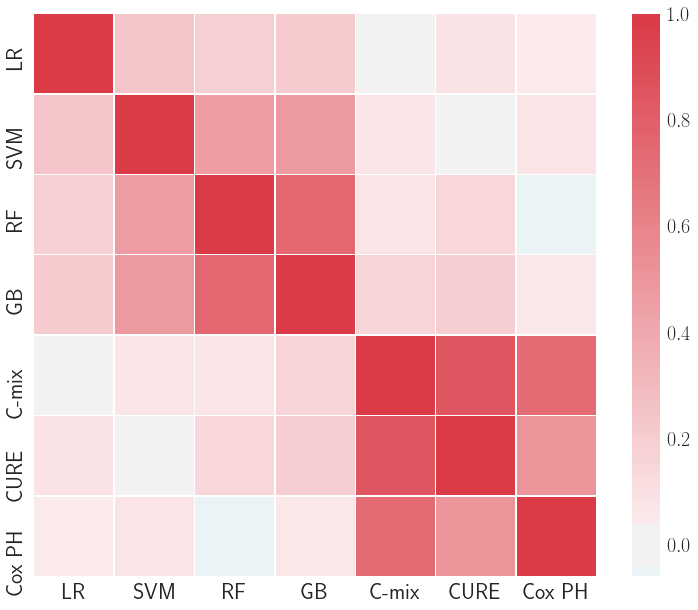

In [22]:
sim = pd.DataFrame(np.array(all_coeffs.ix[:, 1:].T), 
                   columns=list(all_coeffs.Models)).convert_objects(convert_numeric=True)
corr = sim.abs().corr()

sns.set(font_scale=2)
f, ax = pl.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
g = sns.heatmap(corr, cmap=cmap, center=0, mask=np.zeros_like(corr, dtype=np.bool),
                square=True, linewidths=.5)
ax.tick_params(labelsize=22)

pl.savefig('./figures/final/corr.pdf', bbox_inches='tight')
pl.tight_layout()
pl.show()

### Survival estimation on test set for C-mix & CURE

In [23]:
cut = .5
for model in ["C-mix", "CURE"]:
    marker = meta_data.get('marker').get(model)

    %R -i marker,Y_test,delta_test,cut
    %R petit_pi = which(marker < cut)
    %R grand_pi = which(marker > cut)

    # Kaplan-Meier estimators
    %R surv_petit = survfit(Surv(Y_test[petit_pi], delta_test[petit_pi])~1)
    %R surv_grand = survfit(Surv(Y_test[grand_pi], delta_test[grand_pi])~1)

    # Times alignment
    %R surv_petit_fun = stepfun(x=c(0,surv_petit$time),\
                                y=c(1,surv_petit$surv,\
                                    min(surv_petit$surv)))
    %R surv_grand_fun = stepfun(x=c(0,surv_grand$time),\
                                y=c(1,surv_grand$surv,\
                                    min(surv_grand$surv)))

    %R surv_petit2 = apply(matrix(times),1,surv_petit_fun)
    %R surv_grand2 = apply(matrix(times),1,surv_grand_fun)
    %R surv_petit_mat = matrix(rep(surv_petit2,length(Y_test)),\
                               nrow=length(Y_test),\
                               byrow=TRUE)
    %R surv_grand_mat = matrix(rep(surv_grand2,length(Y_test)),\
                               nrow=length(Y_test),\
                               byrow=TRUE)

    %R pi_mat = matrix(rep(marker,nrow(baselinecum)),\
                       ncol=nrow(baselinecum))
    %R survival = pi_mat * surv_grand_mat + (1 - pi_mat) * surv_petit_mat
    %R -o survival,times
    
    times = np.array(times)
    meta_data.get('survival')[model] = np.array(survival)

### Display estimated survival curves for 3 random test examples

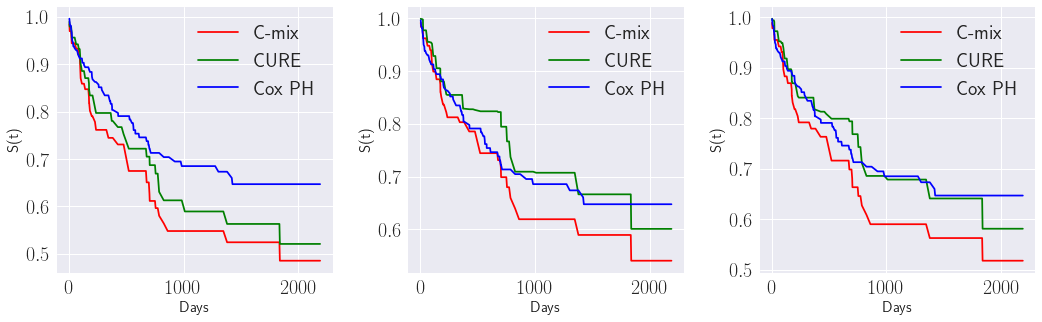

In [24]:
index = np.random.randint(0, len(Y_test), 3)

survival_cmix = meta_data.get('survival').get("C-mix")
survival_CURE = meta_data.get('survival').get("CURE")
survival_cox = meta_data.get('survival').get("Cox PH")

fig = pl.figure(figsize=(15,5))
for i, idx in enumerate(index):    
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(times, survival_cmix[idx, :], "r", label="C-mix")
    ax.plot(times, survival_CURE[idx, :], "g", label="CURE")
    ax.plot(times, survival_cox[idx, :], "b", label="Cox PH")
    
    pl.xlabel('Days', fontsize=15)
    pl.ylabel('S(t)', fontsize=15)
    pl.legend()
pl.tight_layout()
pl.show()

## Use $\mathbb{P}[T_i > \epsilon]$ to predict $T_i > \epsilon$ (binary classif: AUC score)

In [25]:
Auc_cmix, Auc_CURE, Auc_cox = [], [], []

idx2del = []

max_time = 365 * 2
times_ = times[times < max_time]

for i in range(len(times_) - 1):
    eps = times_[i]
    
    # Keep valid examples only 
    idx2keep = ~np.logical_and(delta_test == 0, Y_test <= eps)
    Y_test_ =  Y_test[idx2keep]
    Y_bin_true = (Y_test_ > eps).astype(int)
    
    if np.sum(Y_bin_true) < len(Y_bin_true):

        Y_pred_cmix = survival_cmix[idx2keep, i]
        Y_pred_CURE = survival_CURE[idx2keep, i]
        Y_pred_cox = survival_cox[idx2keep, i]

        auc_cmix = roc_auc_score(Y_bin_true, Y_pred_cmix)
        auc_CURE = roc_auc_score(Y_bin_true, Y_pred_CURE)
        auc_cox = roc_auc_score(Y_bin_true, Y_pred_cox)

        Auc_cmix.append(max(1- auc_cmix, auc_cmix))
        Auc_CURE.append(max(1- auc_CURE, auc_CURE))
        Auc_cox.append(max(1- auc_cox, auc_cox))
        
    else:
        idx2del.append(i)

times_ = np.delete(times_, idx2del)

times_ = times_[:-1]
Auc_cmix_, times_cmix = [Auc_cmix[0]], [times_[0]] 
Auc_CURE_, times_CURE = [Auc_CURE[0]], [times_[0]]
Auc_cox_, times_cox = [Auc_cox[0]], [times_[0]]

for t in range(1, len(times_) - 1):
    if (Auc_cmix[t] != Auc_cmix[t-1] or Auc_cmix[t] != Auc_cmix[t+1]):
        Auc_cmix_ = Auc_cmix_ + [Auc_cmix[t]]
        times_cmix = times_cmix + [times_[t]]
    if (Auc_CURE[t] != Auc_CURE[t-1] or Auc_CURE[t] != Auc_CURE[t+1]):
        Auc_CURE_ = Auc_CURE_ + [Auc_CURE[t]]
        times_CURE = times_CURE + [times_[t]]
    if (Auc_cox[t] != Auc_cox[t-1] or Auc_cox[t] != Auc_cox[t+1]):
        Auc_cox_ = Auc_cox_ + [Auc_cox[t]]
        times_cox = times_cox + [times_[t]]
    
Auc_cmix_ = Auc_cmix_ + [Auc_cmix[-1]]
Auc_CURE_ = Auc_CURE_ + [Auc_CURE[-1]]
Auc_cox_ = Auc_cox_ + [Auc_cox[-1]]
times_cmix = times_cmix + [times_[-1]]
times_CURE = times_CURE + [times_[-1]]
times_cox = times_cox + [times_[-1]]

## Final results: bridge between the 2 setting

In [26]:
# Keep valid examples only
idx2keep = ~np.logical_and(delta_test == 0, Y_test <= threshold)
Y_test_ =  Y_test[idx2keep]
Y_bin_true = (Y_test_ > threshold).astype(int)
idx = np.where(times > threshold)[0][0]

for model in models_survival: 
    survival = meta_data.get('survival').get(model)
    y_pred = survival[idx2keep, idx]
    Y_test_bin_ = Y_bin_true
    roc_auc = roc_auc_score(Y_test_bin_, y_pred)   
    print('%s (%0.3f)' % (model, roc_auc))

C-mix (0.940)
CURE (0.831)
Cox PH (0.861)


# Focus on C-mix benefit: the learned groups

### Survival curves by groups

C-mix: 55 in high-risk group, 14 in low-risk group


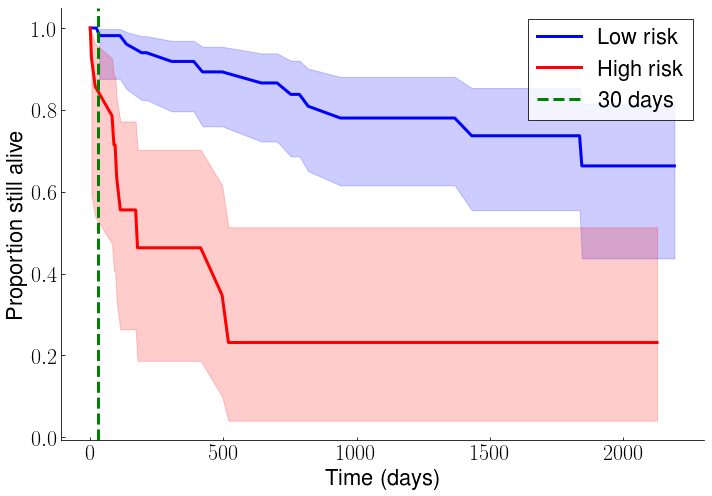

In [44]:
sns.reset_orig()
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

lw = 3
model = "C-mix"
fig = pl.figure(figsize=(10,7))
ax = fig.add_subplot(111)
cut = .5
eps = .05
marker = meta_data.get('marker').get(model)
Z_1 = marker > cut + eps
Z_0 = marker <= cut - eps
print("%s: %s in high-risk group, %s in low-risk group" 
      % (model, np.sum(Z_1), np.sum(Z_0)))

Y_test_0, Y_test_1 = Y_test[Z_1], Y_test[Z_0]
delta_test_0, delta_test_1 = delta_test[Z_1], delta_test[Z_0]

kmf = KaplanMeierFitter()
kmf.fit(Y_test_0, event_observed=delta_test_0)
S_KM_0 = kmf.survival_function_ 
bounds = kmf.confidence_interval_

ax.plot(S_KM_0, '-b', label='Low risk', lw=lw) 
ax.fill_between(bounds.index, bounds['KM_estimate_lower_0.95'],
                bounds['KM_estimate_upper_0.95'], 
                color='b', alpha=0.2)

kmf = KaplanMeierFitter()
kmf.fit(Y_test_1, event_observed=delta_test_1)
S_KM_1 = kmf.survival_function_ 
bounds = kmf.confidence_interval_

ax.plot(S_KM_1, '-r', label='High risk', lw=lw) 
ax.fill_between(bounds.index,bounds['KM_estimate_lower_0.95'],
                bounds['KM_estimate_upper_0.95'], 
                color='r', alpha=0.2)

pl.axvline(x=30, lw=lw, color='g', ls='--', label='30 days')

pl.xlabel('Time (days)', fontsize=22)
pl.ylabel('Proportion still alive', fontsize=22)
ax.tick_params(axis='both', which='major', direction='in',
               labelsize=22)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
leg = pl.legend(prop={'size':22}, fancybox=False)
leg.get_frame().set_edgecolor('black')
pl.tight_layout()
pl.savefig('./figures/final/survival_curves.pdf', bbox_inches='tight')
pl.show()

### Univariate tests based on groups

In [28]:
P_values = pd.DataFrame()

coeffs = meta_data.get('coeffs').get('C-mix')
marker_all = QNEM.predict_proba(X_copy.as_matrix(), fit_intercept, coeffs)
Z_1_cmix = marker_all <= cut
Z_0_cmix = marker_all > cut

X_cont_pos = X_cont[Z_1_cmix]
X_cont_neg = X_cont[Z_0_cmix]
X_bin_pos = X_bin[Z_1_cmix]
X_bin_neg = X_bin[Z_0_cmix]

n_cont = X_cont_pos.shape[1]
n_bin = X_bin_pos.shape[1]

tmp = list()
for i in range(n_cont):
    p_value = stats.mannwhitneyu(X_cont_pos.ix[:, i], 
                                 X_cont_neg.ix[:, i])[1]
    tmp.append(-np.log(p_value))

for i in range(n_bin):
    p_value = stats.fisher_exact([[np.sum(X_bin_pos.ix[:, i] == 0),
                                   np.sum(X_bin_neg.ix[:, i] == 0)],
                                  [np.sum(X_bin_pos.ix[:, i] == 1),
                                   np.sum(X_bin_neg.ix[:, i] == 1)]])[1]
    tmp.append(-np.log(p_value))

columns = list(features_names_cont) + list(binary_features)
P_values_cmix = pd.DataFrame(np.atleast_2d(tmp), columns=columns)
P_values_ordered = P_values_cmix.median().sort_values(ascending=False)
order = ['Setting'] + list(P_values_ordered.index)
tmp = ['C-mix groups'] + tmp
columns = ['Setting'] + list(features_names_cont) + list(binary_features)
P_values = P_values.append(pd.DataFrame(np.atleast_2d(tmp),
                               columns=columns))
print('Done!')

Done!


### Compare with univariate test based on threshold

In [29]:
# Keep valid examples only
X, Y, delta = generate_data(verbose)
idx2keep = ~np.logical_and(delta == 0, Y <= threshold)
Y = Y[idx2keep]
X = X[idx2keep]
features_names = X.columns

Z_1 = Y <= threshold
Z_0 = Y > threshold

# Separate continuous and binary features
X_bin_ = X[binary_features]
X_bin_.index = range(X.shape[0])
X_cont_ = X.drop(binary_features, axis=1)
features_names_cont = X_cont_.columns 
features_names_bin = X_bin_.columns 

n_cont = X_cont_.shape[1]
n_bin = X_bin_.shape[1]

X_cont_pos = X_cont_[Z_1]
X_cont_neg = X_cont_[Z_0]
X_bin_pos = X_bin_[Z_1]
X_bin_neg = X_bin_[Z_0]

tmp = list()
for i in range(n_cont):
    p_value = stats.mannwhitneyu(X_cont_pos.ix[:, i], 
                                 X_cont_neg.ix[:, i])[1]
    tmp.append(-np.log(p_value))

for i in range(n_bin):
    p_value = stats.fisher_exact([[np.sum(X_bin_pos.ix[:, i] == 0),
                                   np.sum(X_bin_neg.ix[:, i] == 0)],
                                  [np.sum(X_bin_pos.ix[:, i] == 1),
                                   np.sum(X_bin_neg.ix[:, i] == 1)]])[1]
    tmp.append(-np.log(p_value))

tmp = [r'$T_i \leq 30$ groups'] + tmp
columns = ['Setting'] + list(features_names_cont) + list(binary_features)
P_values = P_values.append(pd.DataFrame(np.atleast_2d(tmp),
                                        columns=columns))
print('Done!')

Features generation: pick 1 visit per patient randomly
Matrix with all visits loaded
n_visits = 286
Censoring rate: 68.18%
Done!


### Compare with univariate Log-rank test

In [30]:
X, Y, delta = generate_data(verbose)
tmp = list()
for i in range(X.shape[1]):
    X_ = X.ix[:, i]
    global p_value
    %R -i X_,Y,delta
    %R library(survival)
    %R X = as.numeric(X_)
    %R Y = as.numeric(data.matrix(Y))
    %R delta = as.numeric(data.matrix(delta))
    %R data <- list(Y=Y, delta=delta, x=as.vector(X))
    %R res <- coxph(Surv(time=Y, event=delta, type="right") ~ x, data)
    %R p_value = summary(res)$sctest["pvalue"]
    %R -o p_value

    tmp.append(-np.log(p_value[0]))

tmp = ['Log-rank'] + tmp
columns = ['Setting'] + list(X.columns)
P_values = P_values.append(pd.DataFrame(np.atleast_2d(tmp),
                                        columns=columns))
print('Done!')

Features generation: pick 1 visit per patient randomly
Matrix with all visits loaded
n_visits = 286
Censoring rate: 68.18%
Done!


### Plot results for covariates reaching the Bonferonni threshold with $\alpha = 5\%$

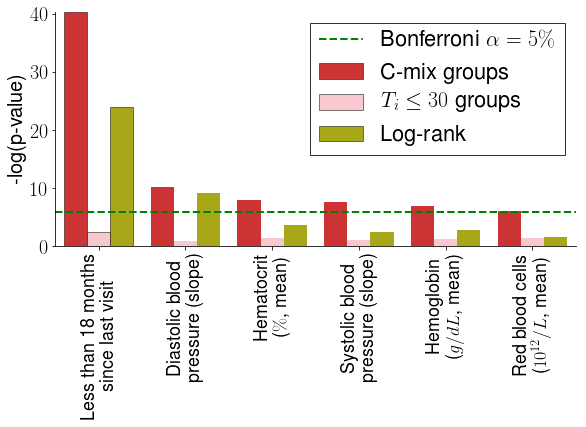

In [31]:
sns.reset_orig()
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

P_values = P_values.reindex_axis(order, axis=1)
n_test = 20
tobekept = pd.DataFrame(np.array(P_values.ix[0, 1:]).astype(float) > -np.log(0.05 / n_test )) 
tobekept = tobekept.ix[0, :]
tobekept = [True] + list(tobekept)
P_values = P_values.ix[:, tobekept]
data = P_values.set_index('Setting').unstack().reset_index().convert_objects(convert_numeric=True)
data.columns = ['','Setting', '-log(p-value)']
palette_tests = {
    'C-mix groups': colors[0],
    r'$T_i \leq 30$ groups': 'pink',
    'Log-rank': 'y'
}

sns.set_context(rc = {'patch.linewidth': 1.0})

pl.figure(figsize=(10, 8))
g = sns.factorplot(x='',
                   y= '-log(p-value)',
                   hue='Setting',
                   data=data,
                   kind='bar',
                   aspect=2,
                   palette=palette_tests,
                   legend=False,
                   edgecolor='black',
                   linewidth=.5)

g.set_ylabels(fontsize = 20)
g.set_xticklabels(rotation=90, fontsize = 18)
pl.tick_params(axis='y', which='major', labelsize=20)
pl.axhline(y=-np.log(0.05/n_test), linewidth=2, color='g', ls='--', label=r'Bonferroni $\alpha=5\%$')
maximum = P_values.convert_objects(convert_numeric=True).max(numeric_only=True).max()
pl.ylim(0, maximum)

leg = pl.legend(fontsize = 22, fancybox=False)
leg.get_frame().set_edgecolor('black')
pl.savefig('./figures/final/test.pdf', bbox_inches='tight')
pl.show()

## Interpretation on initial covariates

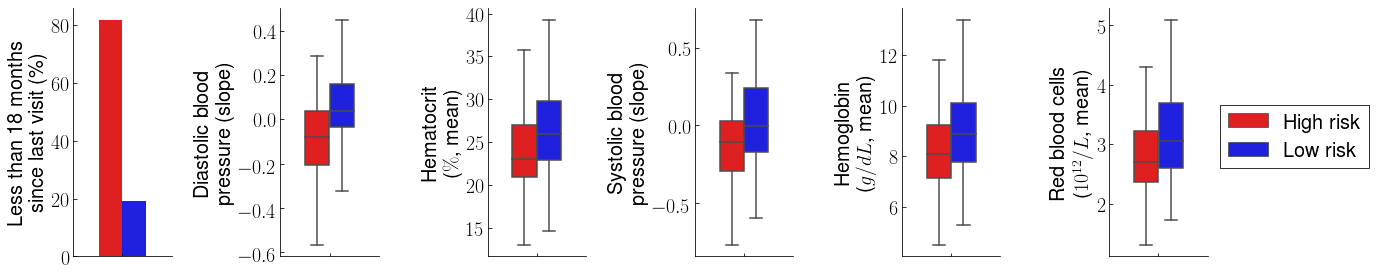

In [33]:
P_values_cmix = P_values_cmix.reindex_axis(order, axis=1)
features2plot = P_values_cmix.columns[P_values_cmix.values[0] > -np.log(0.05 / n_test)]
palette_risk = {
    'High risk': 'r',
    'Low risk': 'b'
}

fig = pl.figure(figsize=(17, 4))
for i, feature in enumerate(features2plot):
            
    ax = fig.add_subplot(1, len(features2plot), i+1)
    data = pd.DataFrame()
    if feature in binary_features:      
        tmp = pd.DataFrame(
                {'percentage': 100 * np.sum(X_copy[feature][Z_1_cmix]) / sum(Z_1_cmix),
                 'Group': ["High risk"],
                 '': [feature]
                })
        data = pd.concat([data, tmp])
        
        tmp = pd.DataFrame(
                {'percentage': 100 * np.sum(X_copy[feature][Z_0_cmix]) / sum(Z_0_cmix),
                 'Group': ["Low risk"],
                 '': [feature]
                })
        data = pd.concat([data, tmp])
                
        g = sns.barplot(x="", 
                        y='percentage', 
                        hue="Group",
                        data=data,
                        palette=palette_risk,
                        ax=ax)
        
        newwidth = .24
        for i, bar in enumerate(ax.patches):
            x = bar.get_x()
            width = bar.get_width()
            if (i == 0):
                bar.set_x(x + width - newwidth)
            bar.set_width(newwidth)
        
        feature += ' (\%)'
        
    else:
        tmp = pd.DataFrame(
                {feature: X_cont[feature][Z_1_cmix],
                 'Group': ["High risk"] * np.sum(Z_1_cmix),
                 '': [feature] * np.sum(Z_1_cmix)
                })
        data = pd.concat([data, tmp])

        tmp = pd.DataFrame(
                {feature: X_cont[feature][Z_0_cmix],
                 'Group': ["Low risk"] * np.sum(Z_0_cmix),
                 '': [feature] * np.sum(Z_0_cmix)
                })
        data = pd.concat([data, tmp])
        
        g = sns.boxplot(x="", 
                        y=feature, 
                        hue="Group",
                        data=data,
                        palette=palette_risk,
                        ax=ax,
                        width=.5,
                        showfliers=False)
        
    g.set(xticklabels=[])
    g.set_ylabel(feature, fontsize=20)

    ax.tick_params(axis='both', which='major', direction='in',
                   labelsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    ax.legend_.remove()
        
leg = pl.legend(prop={'size':20}, fancybox=False,
               bbox_to_anchor=(1.02, 0.65), loc=2)
leg.get_frame().set_edgecolor('black')
pl.tight_layout()
pl.savefig('./figures/final/boxplot.pdf', bbox_inches='tight')
pl.show()